# **Computer Vision Assignment 5**

In [ ]:
! pip install aicrowd-cli

In [7]:
API_KEY = "375767f7b488df578d5c7e7ef9545f2d" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
! aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [8]:
! aicrowd dataset download --challenge chunin-exams-food-track-cv-2021

train_images.zip: 100% 754M/754M [00:19<00:00, 39.5MB/s]
test_images.zip: 100% 33.9M/33.9M [00:01<00:00, 27.2MB/s]
train.csv: 100% 253k/253k [00:00<00:00, 1.03MB/s]
test.csv: 100% 7.27k/7.27k [00:00<00:00, 917kB/s]


In [5]:
! wget https://gitlab.aicrowd.com/aicrowd/practice-challenges/aicrowd_FOODC_challenge/-/raw/master/dataset_info.txt

--2021-04-18 11:19:51--  https://gitlab.aicrowd.com/aicrowd/practice-challenges/aicrowd_FOODC_challenge/-/raw/master/dataset_info.txt
Resolving gitlab.aicrowd.com (gitlab.aicrowd.com)... 18.194.250.154, 18.195.114.113
Connecting to gitlab.aicrowd.com (gitlab.aicrowd.com)|18.194.250.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3451 (3.4K) [text/plain]
Saving to: ‘dataset_info.txt’

dataset_info.txt    100%[===================>]   3.37K  --.-KB/s    in 0s      

2021-04-18 11:19:52 (526 MB/s) - ‘dataset_info.txt’ saved [3451/3451]



In [151]:
# library imports
import os
import tqdm
import random
import time
import shutil
import cv2
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

In [4]:
! rm -r data

In [5]:
! unzip train_images.zip
! unzip test_images.zip

! mkdir data
! mkdir data/train
! mkdir data/val

In [6]:
! ls -1 test_images | wc -l
! cat test.csv | wc -l

! ls -1 train_images | wc -l
! cat train.csv | wc -l

484
485
9323
9324


Creating label array

In [7]:
with open('dataset_info.txt', 'r') as f:
  labels = f.read()

labels = labels.split('\n')[1:]
labels = [ i.strip().split('. ')[-1] for i in labels ]
labels[:5]

['BG', 'water', 'pizza-margherita-baked', 'broccoli', 'salad-leaf-salad-green']

Making label -> index and index -> label mapping

In [8]:
lbl2idx = {}
for i in range(len(labels)):
  lbl2idx[labels[i]] = i

idx2lbl = {}
for i in range(len(labels)):
  idx2lbl[i] = labels[i]

In [9]:
for i in labels:
  os.mkdir('data/train/' + i)
  os.mkdir('data/val/' + i)

Splitting data into train and val

In [10]:
classwise_alltrain_images = {}
classwise_train_images = {}
classwise_val_images = {}

with open('train.csv', 'r') as f:
  trainData = f.read()

trainData = trainData.split('\n')[1:-1]
trainData = [ i.split(',') for i in trainData ]
for i in trainData:
  try:
    classwise_alltrain_images[i[1]]
    classwise_alltrain_images[i[1]].append(i[0])
  except:
    classwise_alltrain_images[i[1]] = []

In [11]:
for i in classwise_alltrain_images.keys():
  sizee = int(len(classwise_alltrain_images[i]) * 0.7)
  for j in range(sizee):
    classwise_alltrain_images[i].pop()

In [12]:
for i in classwise_alltrain_images.keys():
  trainSamples = int(len(classwise_alltrain_images[i]) * 0.8)
  trainSamples = random.sample(range(0, len(classwise_alltrain_images[i])), trainSamples)
  testSamples = [ j for j in range(len(classwise_alltrain_images[i])) if j not in trainSamples ]
  classwise_train_images[i] = [classwise_alltrain_images[i][j] for j in trainSamples]
  classwise_val_images[i] = [classwise_alltrain_images[i][j] for j in testSamples]

In [13]:
for i in classwise_train_images.keys():
  for j in classwise_train_images[i]:
    shutil.copyfile('train_images/' + j, 'data/train/' + i + '/' + j)

In [14]:
for i in classwise_val_images.keys():
  for j in classwise_val_images[i]:
    shutil.copyfile('train_images/' + j, 'data/val/' + i + '/' + j)

Making list of all training and validation samples

In [15]:
train_images_list = []
train_labels_list = []
for i in classwise_train_images.keys():
  for j in classwise_train_images[i]:
    train_images_list.append('data/train/' + i + '/' + j)
    train_labels_list.append(lbl2idx[i])

val_images_list = []
val_labels_list = []
for i in classwise_val_images.keys():
  for j in classwise_val_images[i]:
    val_images_list.append('data/val/' + i + '/' + j)
    val_labels_list.append(lbl2idx[i])

Custom Food Dataset Dataset

In [209]:
class FoodData(Dataset):
  def __init__(self, list_images, list_labels):
    self.list_images = list_images
    self.list_labels = list_labels

  def __len__(self):
    return len(self.list_labels)

  def __getitem__(self, index):
    img = cv2.imread(self.list_images[index], 0)
    img = cv2.resize(img, (256, 256)).astype(np.float64) / 255
    img = img.flatten()
    lbl = np.zeros(len(labels)).astype(np.float)
    lbl[self.list_labels[index]] = 1
    return {'feature': img, 'label': lbl}

Creating Dataset object

In [210]:
train_dl = FoodData(train_images_list, train_labels_list)
val_dl = FoodData(val_images_list, val_labels_list)

In [211]:
train_dl.__getitem__(0)['feature'].shape

(65536,)

Dataloader

In [212]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = False, batch_size = 128, num_workers = 2)
val_dataloader = torch.utils.data.DataLoader(val_dl, shuffle = True, batch_size = 128, num_workers = 2)

Model

In [213]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.ReLU(),
        nn.Linear(1024, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

Training code

In [214]:
def check_cuda():
    _cuda = False
    if torch.cuda.is_available():
        _cuda = True
    return _cuda

In [215]:
def train_model(model, train_loader, val_loader):
    n_epochs = 10
    bestModel = model
    bestLoss = 1000000
    
    for epoch in range(n_epochs):
        train_loss = 0.0
        model.train()
        for data_tmp in tqdm.tqdm(train_loader):
            # move tensors to GPU
            data, target = data_tmp['feature'].cuda().float(), data_tmp['label'].cuda().float()
            optimizer.zero_grad()
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        lossVal = val_model(model, val_dataloader)
        train_losses.append(train_loss)
        if lossVal < bestLoss:
          bestLoss = lossVal
          bestModel = model
    return model

In [216]:
def val_model(model, test_loader):
    losss = 0.0
    correct = 0
    total = 0

    model.eval()
    for data_tmp in tqdm.tqdm(test_loader):
        # move tensors to GPU
        data, target = data_tmp['feature'].cuda().float(), data_tmp['label'].cuda().float()
        output = model(data)
        loss = criterion(output, target)
        losss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        _, gt = torch.max(target, 1)
        correct += (pred == gt).sum().cpu().detach().numpy()
        total += len(gt)
    val_losses.append(losss)
    print('\nValidation loss =',losss)
    print('Validation accuracy =', (correct / total) * 100, '%')
    return losss

In [217]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

In [218]:
def plotGraph(epochs, train, val, labels):
  plt.figure(figsize=(10, 10))
  for j in range(len(train)):
    plt.plot([ i + 1 for i in range(epochs) ], train[j], linestyle='solid', label='Train Loss: ' + labels[j])
    plt.plot([ i + 1 for i in range(epochs) ], val[j], linestyle='dotted', label='Validation Loss: ' + labels[j])
  plt.legend()

In [219]:
train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.231875


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 76.08961963653564
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.147145


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 74.11666160821915
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.145298


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 55.099739611148834
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.109318


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 56.509683072566986
Validation accuracy = 3.4013605442176873 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.111778


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.66549187898636
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.102286


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.797542452812195
Validation accuracy = 3.741496598639456 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.101923


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.65689700841904
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.098522


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.38985678553581
Validation accuracy = 3.571428571428571 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.097375


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.968757688999176
Validation accuracy = 3.741496598639456 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.095858


100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Validation loss = 50.72527480125427
Validation accuracy = 3.741496598639456 %


In [220]:
plotTrain, plotVal = [], []
plotTrain.append(np.array(train_losses))
plotVal.append(np.array(val_losses))

### **1) With Batch Norm**

In [221]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [222]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.552203


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 252.4161093235016
Validation accuracy = 1.530612244897959 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.224793


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 97.54006487131119
Validation accuracy = 1.7006802721088436 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.134125


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 64.78064098954201
Validation accuracy = 3.061224489795918 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.107165


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 60.167293816804886
Validation accuracy = 3.741496598639456 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.094596


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 56.943482398986816
Validation accuracy = 4.421768707482993 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.086797


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 55.4551083445549
Validation accuracy = 4.761904761904762 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.081257


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 54.02782961726189
Validation accuracy = 5.1020408163265305 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.076980


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.86738437414169
Validation accuracy = 5.272108843537415 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.073488


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.15265494585037
Validation accuracy = 5.272108843537415 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.070537


100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Validation loss = 51.44371783733368
Validation accuracy = 5.612244897959184 %


In [223]:
plotTrain.append(np.array(train_losses))
plotVal.append(np.array(val_losses))

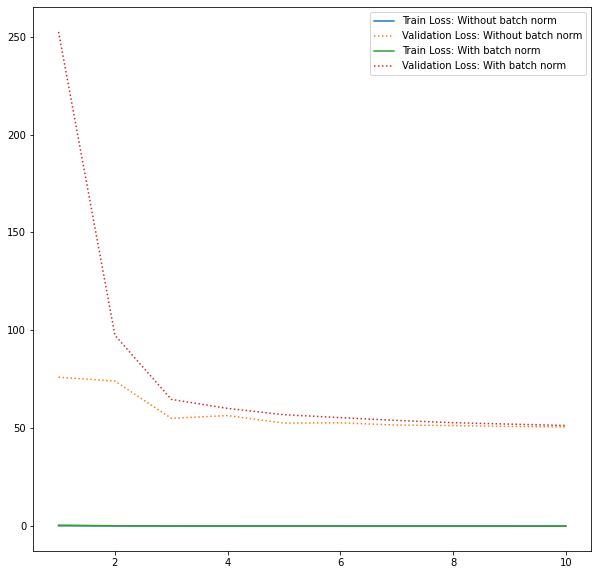

In [226]:
plotGraph(10, plotTrain, plotVal, ['Without batch norm', 'With batch norm'])

With batch normalization the accuracy increased from 3.74% to 5.61%

### **2) Adding new layers**

In [227]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.ReLU(),
        nn.Linear(1024, 512, bias=True), 
        nn.ReLU(),
        nn.Linear(512, 128, bias=True), 
        nn.ReLU(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [228]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.617600


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 229.14795112609863
Validation accuracy = 0.5102040816326531 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.165271


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 70.37047472596169
Validation accuracy = 3.741496598639456 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.116504


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 54.52801811695099
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.095081


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.746523052453995
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.091396


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.62045130133629
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.090875


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.151668936014175
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.089930


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.19689694046974
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.089930


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.05526101589203
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.089536


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.04879587888718
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.089438


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss = 49.989782869815826
Validation accuracy = 6.122448979591836 %


In [232]:
plotTrain.pop()
plotVal.pop()
plotTrain.append(train_losses)
plotVal.append(val_losses)

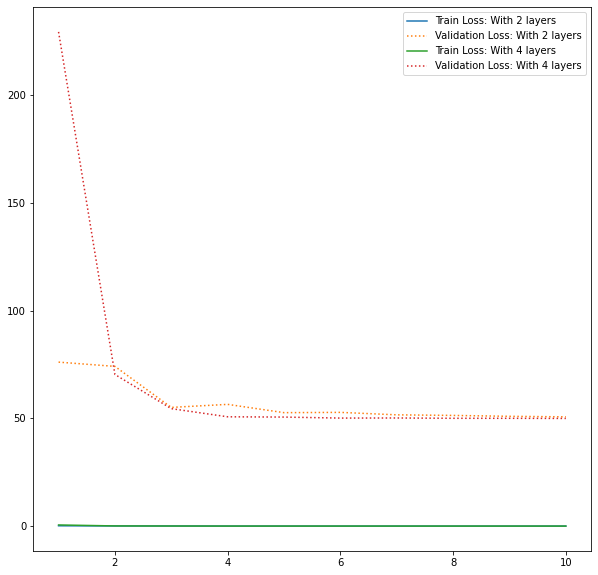

In [234]:
plotGraph(10, plotTrain, plotVal, ['With 2 layers', 'With 4 layers'])

With 2 layers we get an accuracy of 3.74% and with 4 layers we get 6.12% as accuracy.

### **3) With Dropout**

In [237]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(1024, 512, bias=True), 
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(512, 128, bias=True), 
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [238]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.649218


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 295.3255338668823
Validation accuracy = 0.8503401360544218 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.246127


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 70.66783928871155
Validation accuracy = 1.7006802721088436 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.132977


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.25037285685539
Validation accuracy = 5.272108843537415 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.100875


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.41788274049759
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.097483


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.432712227106094
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.096762


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.03828951716423
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.095416


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 49.99718490242958
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.094315


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 49.92035558819771
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.093877


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 49.90624052286148
Validation accuracy = 8.503401360544217 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.093133


100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Validation loss = 49.86475297808647
Validation accuracy = 8.843537414965986 %


In [240]:
plotTrain = plotTrain[1:]
plotVal = plotVal[1:]
plotTrain.append(train_losses)
plotVal.append(val_losses)

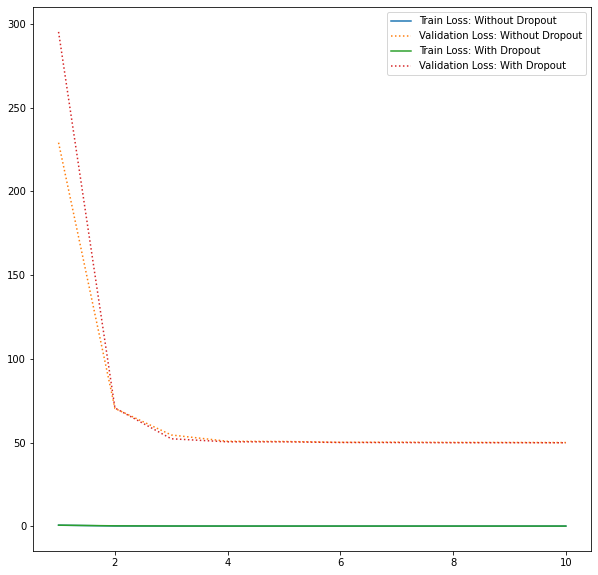

In [241]:
plotGraph(10, plotTrain, plotVal, ['Without Dropout', 'With Dropout'])

I used the 4 layered model to compare.

Model without dropout -> Accuracy: 6.12%

Model with dropout -> Accuracy: 8.84%

### **4) Different activation functions at the end**

In [243]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.LeakyReLU(),
        nn.Linear(1024, 512, bias=True), 
        nn.LeakyReLU(),
        nn.Linear(512, 128, bias=True), 
        nn.LeakyReLU(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [244]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.660827


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 334.0959782600403
Validation accuracy = 1.3605442176870748 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.292428


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 62.65189254283905
Validation accuracy = 2.5510204081632653 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.124772


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 54.22434061765671
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.093036


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.40136617422104
Validation accuracy = 3.231292517006803 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.090870


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.31442278623581
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.090088


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.14449945092201
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.089236


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.03304806351662
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.089092


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 49.98606899380684
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.088883


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 49.95114850997925
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.088736


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Validation loss = 49.92622631788254
Validation accuracy = 6.122448979591836 %


In [245]:
plotTrain = plotTrain[:-1]
plotVal = plotVal[:-1]
plotTrain.append(train_losses)
plotVal.append(val_losses)

In [246]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.Tanh(),
        nn.Linear(1024, 512, bias=True), 
        nn.Tanh(),
        nn.Linear(512, 128, bias=True), 
        nn.Tanh(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [247]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.544332


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 256.9303117990494
Validation accuracy = 0.3401360544217687 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.357586


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 159.53009700775146
Validation accuracy = 1.870748299319728 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.223207


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 104.87046736478806
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.156919


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 80.43067002296448
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.126757


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 68.62255263328552
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.111345


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 62.08097431063652
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.102370


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 58.03243452310562
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.096608


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 55.32351553440094
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.092649


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 53.40842670202255
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.089793


100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


Validation loss = 51.99867391586304
Validation accuracy = 8.843537414965986 %


In [248]:
plotTrain.append(train_losses)
plotVal.append(val_losses)

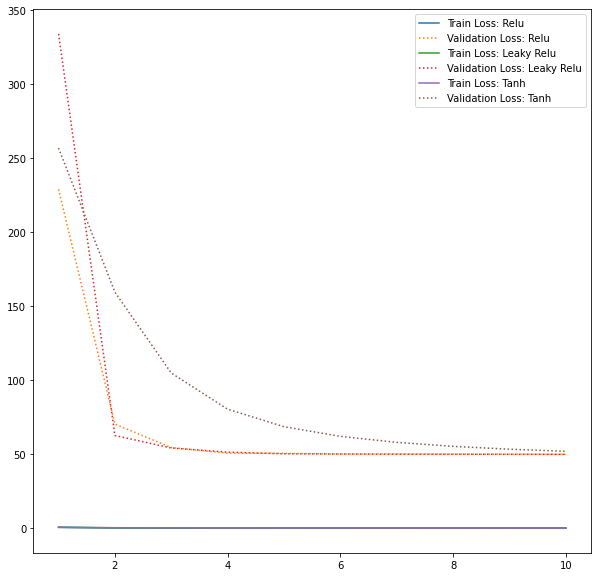

In [249]:
plotGraph(10, plotTrain, plotVal, ['Relu', 'Leaky Relu', 'Tanh'])

Accuracies on validation set with different activations:

ReLu: 6.12

Leaky ReLu: 6.12

Tanh: 8.84

### **5) Different pooling strategies**

In [250]:
plotTrain = []
plotVal = []

In [251]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.MaxPool1d(3, stride=2),
        nn.Linear(32767, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, len(labels), bias=True)
    )

  def forward(self, x):
    x = x.unsqueeze(0)
    return torch.sigmoid(self.layer1(x)).squeeze()

In [252]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.269428


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 66.30125126242638
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.133731


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 61.892758041620255
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.114327


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 55.8892283141613
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.106279


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.07243573665619
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.100477


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.09781938791275
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.099431


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.24644646048546
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.097499


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.12656047940254
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.096658


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.7566379904747
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.095496


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.58683556318283
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.094718


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Validation loss = 50.38793495297432
Validation accuracy = 3.741496598639456 %


In [253]:
plotTrain.append(train_losses)
plotVal.append(val_losses)

In [254]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.AvgPool1d(3, stride=2),
        nn.Linear(32767, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, len(labels), bias=True)
    )

  def forward(self, x):
    x = x.unsqueeze(0)
    return torch.sigmoid(self.layer1(x)).squeeze()

In [255]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.277696


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 65.4512625336647
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.132821


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 59.54282867908478
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.108712


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 56.92515170574188
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.107272


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.63068664073944
Validation accuracy = 3.741496598639456 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.098644


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.50720167160034
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.099757


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.26710167527199
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.097043


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.439694315195084
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.096912


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.97830730676651
Validation accuracy = 4.2517006802721085 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.095559


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.9205616414547
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.095078


100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Validation loss = 50.69638013839722
Validation accuracy = 4.081632653061225 %


In [256]:
plotTrain.append(train_losses)
plotVal.append(val_losses)

In [257]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.LPPool1d(2, 3, stride=2),
        nn.Linear(32767, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, len(labels), bias=True)
    )

  def forward(self, x):
    x = x.unsqueeze(0)
    return torch.sigmoid(self.layer1(x)).squeeze()

In [258]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.217420


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 86.64992952346802
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.163874


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 77.54881748557091
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.154388


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 55.33423396945
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.108692


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 55.78248280286789
Validation accuracy = 4.421768707482993 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.110473


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 52.439799070358276
Validation accuracy = 3.741496598639456 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.101527


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.762109994888306
Validation accuracy = 4.2517006802721085 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.099729


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.13803455233574
Validation accuracy = 3.741496598639456 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.097234


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.72409197688103
Validation accuracy = 4.591836734693878 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.095844


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.4451097548008
Validation accuracy = 4.591836734693878 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.094534


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Validation loss = 50.19463407993317
Validation accuracy = 5.782312925170068 %


In [259]:
plotTrain.append(train_losses)
plotVal.append(val_losses)

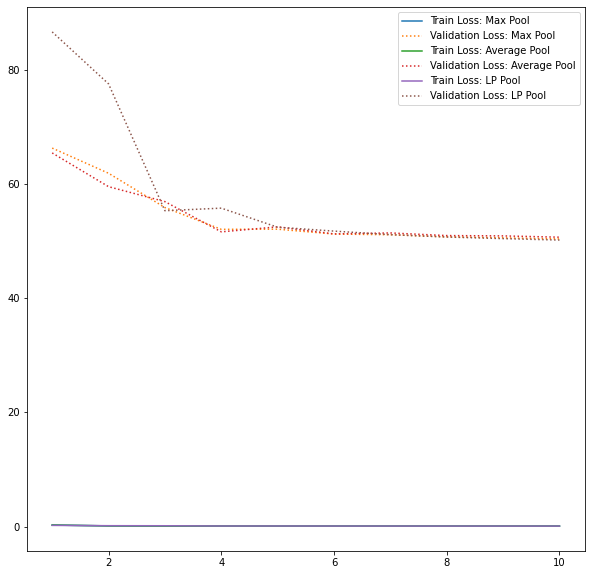

In [260]:
plotGraph(10, plotTrain, plotVal, ['Max Pool', 'Average Pool', 'LP Pool'])

Max Pool: 3.74%

Average Pool: 4.08%

LP Pool: 5.78%

### **6) Different optimizers**

In [263]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.ReLU(),
        nn.Linear(1024, 512, bias=True), 
        nn.ReLU(),
        nn.Linear(512, 128, bias=True), 
        nn.ReLU(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [264]:
plotTrain = []
plotVal = []

In [265]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr = 0.01, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 13.206466


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8988.9697265625
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 15.771562


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 9870.967567443848
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 16.268009


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8970.26037979126
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 15.232396


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8970.345157623291
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 15.232269


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8969.892669677734
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 14.763776


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8040.39485168457
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 13.647730


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8041.205093383789
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 13.647319


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8041.156879425049
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 13.647116


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 8040.65767288208
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 13.646739


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Validation loss = 8039.949131011963
Validation accuracy = 8.843537414965986 %


In [266]:
plotTrain.append(train_losses)
plotVal.append(val_losses)

In [267]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.ReLU(),
        nn.Linear(1024, 512, bias=True), 
        nn.ReLU(),
        nn.Linear(512, 128, bias=True), 
        nn.ReLU(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [268]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 3.150906


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322065353394
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322065353394
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322065353394
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.032238960266
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0321779251099
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322513580322
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0321741104126
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322065353394
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322227478027
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 2.924750


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss = 1729.0322046279907
Validation accuracy = 8.843537414965986 %


In [269]:
plotTrain.append(train_losses)
plotVal.append(val_losses)

In [270]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.ReLU(),
        nn.Linear(1024, 512, bias=True), 
        nn.ReLU(),
        nn.Linear(512, 128, bias=True), 
        nn.ReLU(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [271]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.964819


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0321884155273
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322227478027
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.0322227478027
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.032190322876
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.032220840454
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 2.924750


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 1729.032220840454
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 3.531164


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 2748.386999130249
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 4.670002


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 2748.3869953155518
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 4.670002


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 2748.3870277404785
Validation accuracy = 4.081632653061225 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 4.670002


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss = 2748.3869953155518
Validation accuracy = 4.081632653061225 %


In [272]:
plotTrain.append(train_losses)
plotVal.append(val_losses)

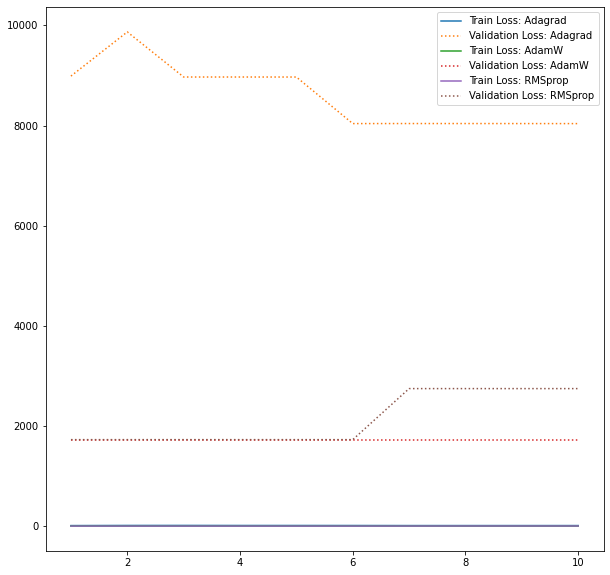

In [273]:
plotGraph(10, plotTrain, plotVal, ['Adagrad', 'AdamW', 'RMSprop'])

Adagrad: 8.84%

AdamW: 8.84%

RMSprop: 4.08%

### **7) Basic Augmentation like Rotation, Translation, Color Change**

In [277]:
class FoodData(Dataset):
  def __init__(self, list_images, list_labels):
    self.list_images = list_images
    self.list_labels = list_labels

  def __len__(self):
    return len(self.list_labels)

  def __getitem__(self, index):
    img = cv2.imread(self.list_images[index], 0)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter()
    ])
    img = np.array(transform(img))
    img = img.astype(np.float64)
    img = cv2.resize(img, (256, 256)).astype(np.float64) / 255
    img = img.flatten()
    lbl = np.zeros(len(labels)).astype(np.float)
    lbl[self.list_labels[index]] = 1
    return {'feature': img, 'label': lbl}

In [278]:
train_dl = FoodData(train_images_list, train_labels_list)
val_dl = FoodData(val_images_list, val_labels_list)

In [279]:
train_dl.__getitem__(0)['feature'].shape

(65536,)

In [280]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = False, batch_size = 128, num_workers = 2)
val_dataloader = torch.utils.data.DataLoader(val_dl, shuffle = True, batch_size = 128, num_workers = 2)

In [281]:
class FoodClassifier(nn.Module):
  def __init__(self):
    super(FoodClassifier, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(256*256, 1024, bias=True), 
        nn.ReLU(),
        nn.Linear(1024, 512, bias=True), 
        nn.ReLU(),
        nn.Linear(512, 128, bias=True), 
        nn.ReLU(),
        nn.Linear(128, len(labels), bias=True)
    )

  def forward(self, x):
    return torch.sigmoid(self.layer1(x))

In [282]:
is_cuda = check_cuda()
model = FoodClassifier()
if is_cuda:
    model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

train_losses, val_losses = [], []
model = train_model(model, train_dataloader, val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.645859


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 299.15508365631104
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.231675


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 69.5157799422741
Validation accuracy = 3.9115646258503403 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.125125


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.801527708768845
Validation accuracy = 8.843537414965986 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.090549


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 51.42090365290642
Validation accuracy = 6.292517006802721 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.091247


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.2048225402832
Validation accuracy = 6.292517006802721 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.090162


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.16711845993996
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.089641


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.14808988571167
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.089621


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.081119775772095
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.089412


  0%|          | 0/18 [00:00<?, ?it/s]


Validation loss = 50.12529644370079
Validation accuracy = 6.122448979591836 %


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.089376


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Validation loss = 50.10658100247383
Validation accuracy = 6.122448979591836 %


Augmentation creates more variety of images, hence overfitting is reduced and accuracy increases.